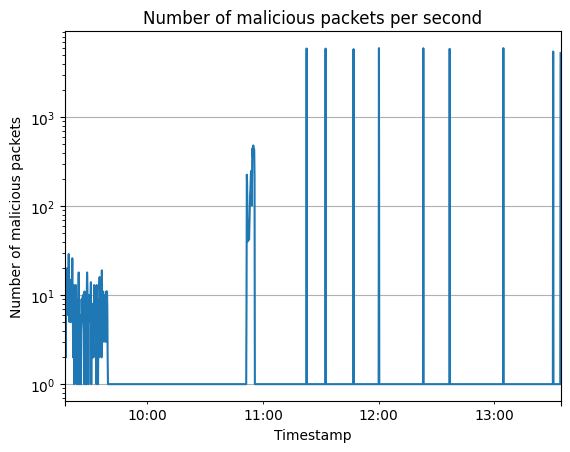

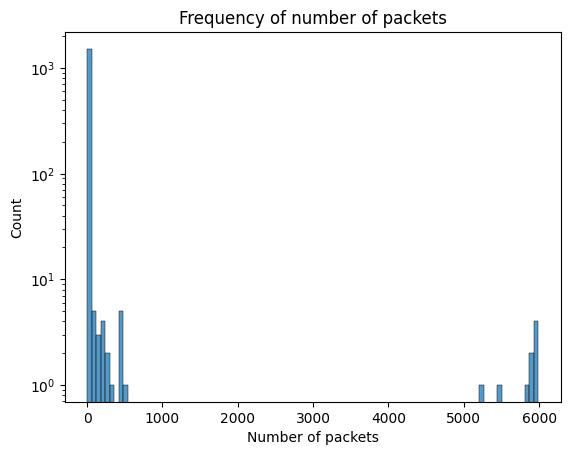

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ddos_data = pd.read_csv('ddos_dataset.csv', low_memory=False)

operational_df = ddos_data.copy()
operational_df[' Timestamp'] = pd.to_datetime(operational_df[' Timestamp'])
operational_df.set_index(' Timestamp', inplace=True)
mask_malicious = operational_df['label'] != 'benign'
df_result = operational_df[mask_malicious].resample('10S').count()

df_result['Flow ID'].replace(0, 1).plot()
plt.xlabel('Timestamp')
plt.ylabel('Number of malicious packets')
plt.yscale('log')
plt.title('Number of malicious packets per second')
plt.grid()
plt.show()

plt.figure()
sns.histplot(data=df_result.replace(0, 1), x='Flow ID', bins=100)
plt.xlabel('Number of packets')
plt.title('Frequency of number of packets')
plt.yscale('log')
plt.show()

Let's analyze the top 5 destination IP reached by attacks

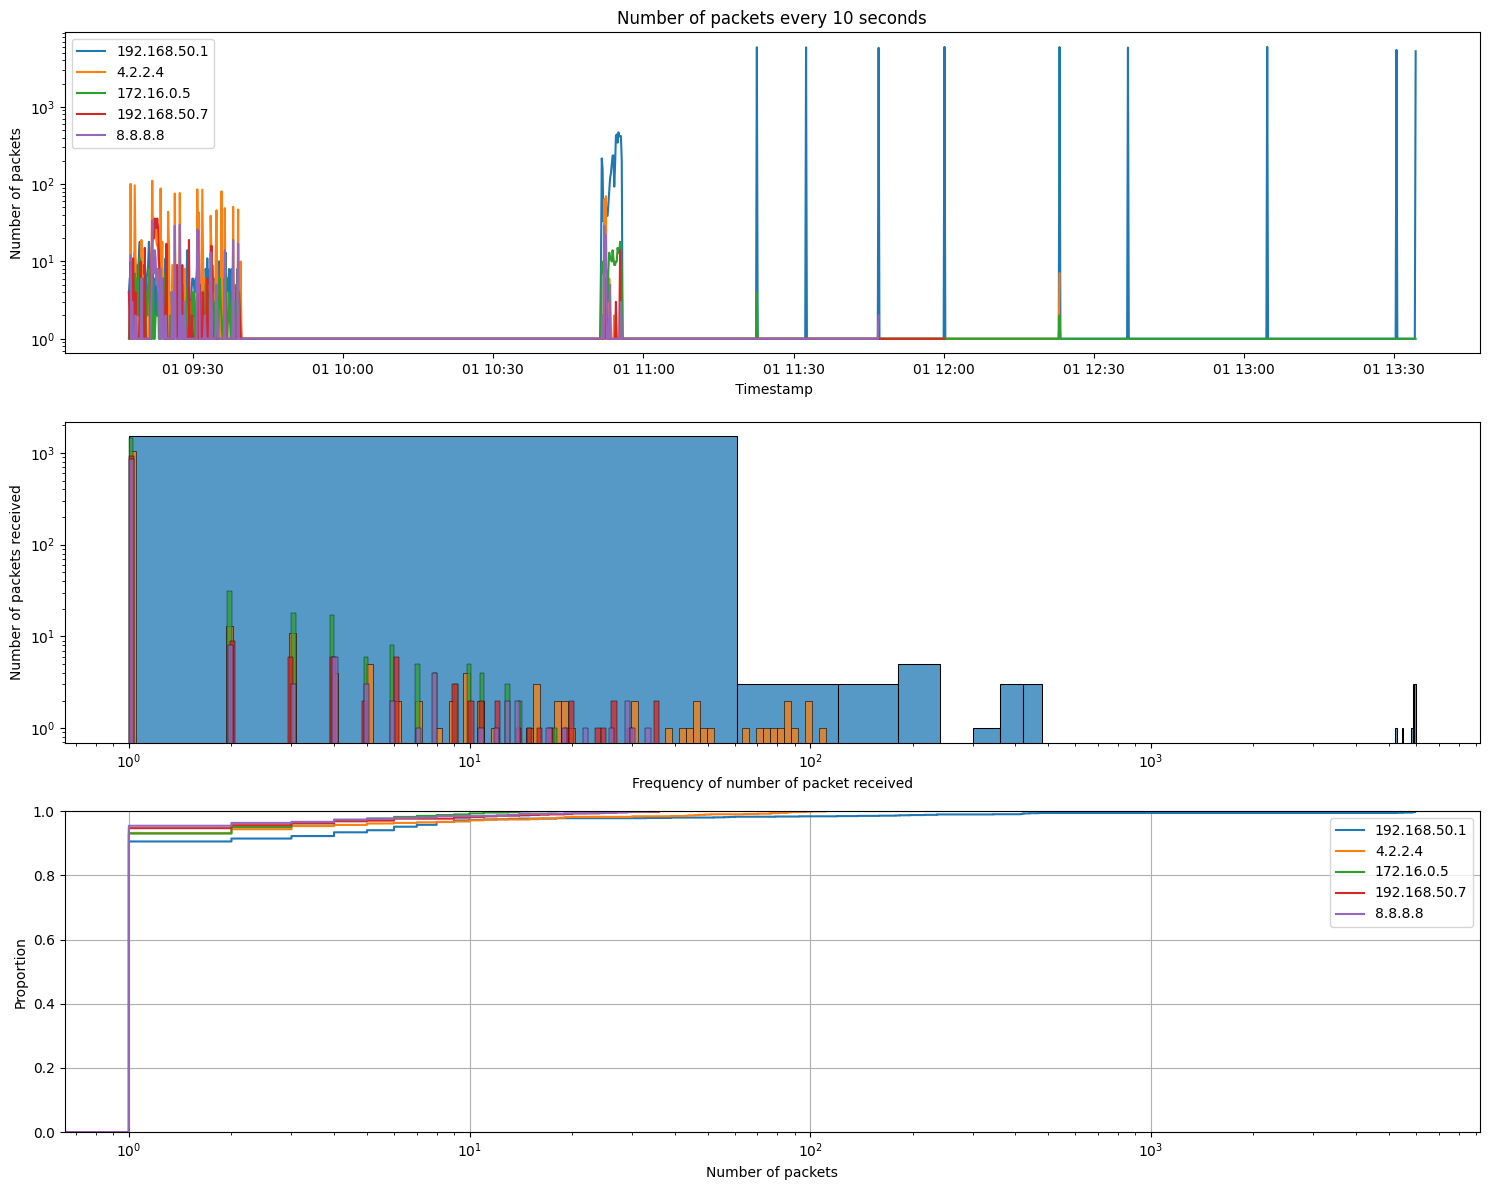

In [110]:
ip_top5 = operational_df.groupby(' Destination IP').count().sort_values(by='Flow ID', ascending=False).index[:5]
num_packets = []
t_df = operational_df.copy()
fig, ax = plt.subplots(3, 1, figsize=(15, 12))

# since I'm using a logarithmic scale I have to take care of 0 values and replace it with 1

for ip in ip_top5:
    mask_ip = t_df[' Destination IP'] == ip
    temp_df = t_df[mask_ip].resample('10S').count()
    sns.lineplot(data=temp_df.replace(0,1), y=' Destination IP', x=' Timestamp', label=ip, ax=ax[0])
    ax[0].set_title('Number of packets every 10 seconds')
    ax[0].set_ylabel('Number of packets')
    ax[0].set_yscale('log')
    sns.histplot(data=temp_df[' Destination IP'].replace(0,1), label=ip, bins=100, ax=ax[1])
    ax[1].set_ylabel('Number of packets received')
    ax[1].set_xlabel('Frequency of number of packet received')
    ax[1].set_yscale('log')
    ax[1].set_xscale('log')
    sns.ecdfplot(data=temp_df[' Destination IP'].replace(0, 1), label=ip, ax=ax[2])
    ax[2].set_xlabel('Number of packets')
    ax[2].set_xscale('log')
    
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

Since the top IP destination has received a lot more packets in respect of the other, let's exclude it and analyze the other 4 for a clear representation of also the othre targeted IP

 Protocol
0        18
6     11857
17    46706
Name: Flow ID, dtype: int64


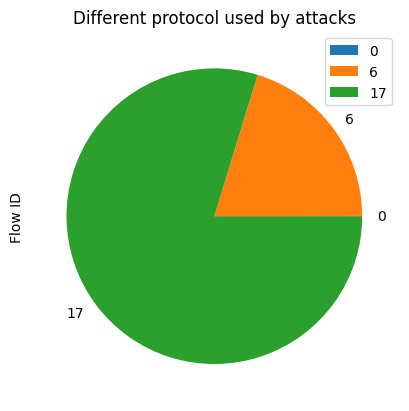

In [111]:
malicious_df = operational_df[mask_malicious].copy()
protocol_df = malicious_df.groupby(' Protocol').count()['Flow ID']
protocol_df.plot(kind='pie', title='Different protocol used by attacks')
plt.legend()
print(protocol_df)

Even if the protol 0 seems to be not used, it is indeed. This visualization is due to the fact that the count for each protocol is:<br>
0        18, <br>
6     11857, <br>
17    46706 <br>

Now it's time to analyze the kind of attack or data flow characterized by the SYN flag high in the TCP protocol

<Axes: xlabel='label'>

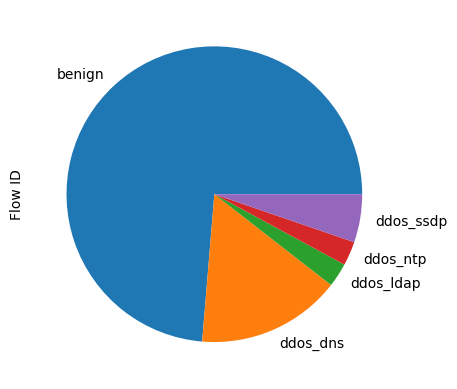

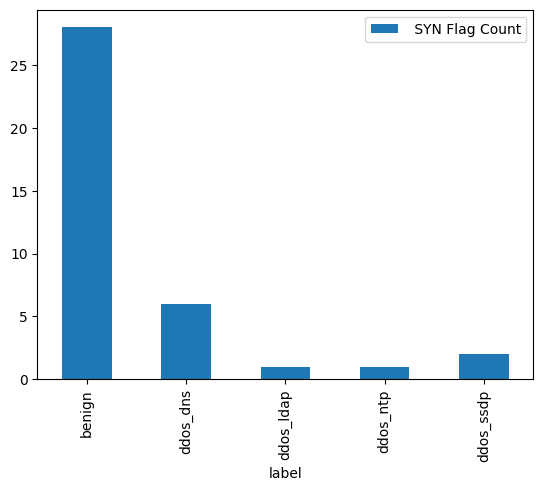

In [112]:
mask_SYN = operational_df[' SYN Flag Count'] != 0
SYN_df = operational_df[mask_SYN].groupby('label').count()['Flow ID']
SYN_df.plot(kind='pie')
at_SYN_df = operational_df[mask_SYN]
at_SYN_df[[' SYN Flag Count', 'label']].groupby('label').count().plot(kind='bar')

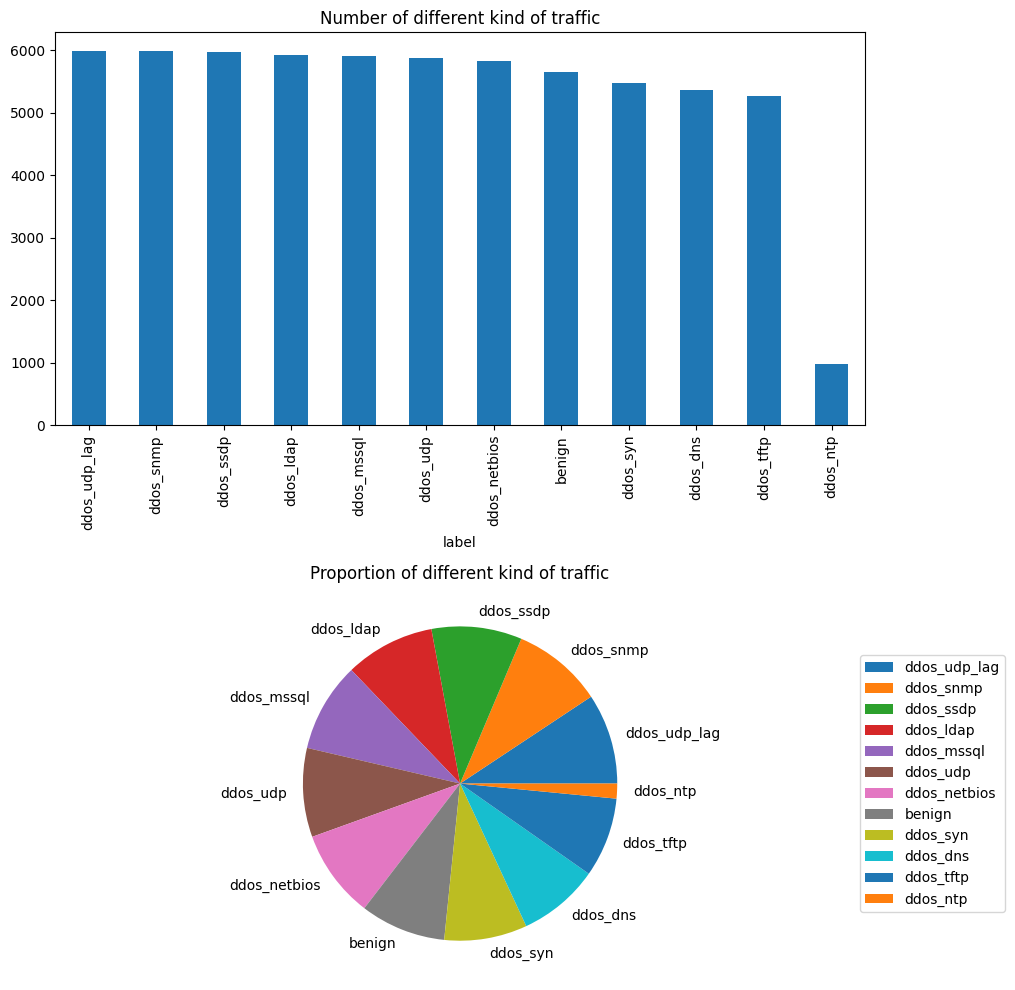

In [113]:
df_attacks = operational_df.groupby('label').count().sort_values(by='Flow ID', ascending=False)
attacks = df_attacks.index
fig, ax = plt.subplots(2,1)
df_attacks['Flow ID'].plot(kind='bar', title='Number of different kind of traffic', ax=ax[0], figsize=(10,2))
df_attacks.plot(kind='pie', y='Flow ID', ax=ax[1], title='Proportion of different kind of traffic', figsize=(10,10))
ax[1].legend(loc='center left', bbox_to_anchor=(1.5, 0.5))
ax[1].set_ylabel('')

plt.tight_layout()

<Axes: title={'center': 'Top 10 Flow ID number of packets'}, xlabel='Flow ID'>

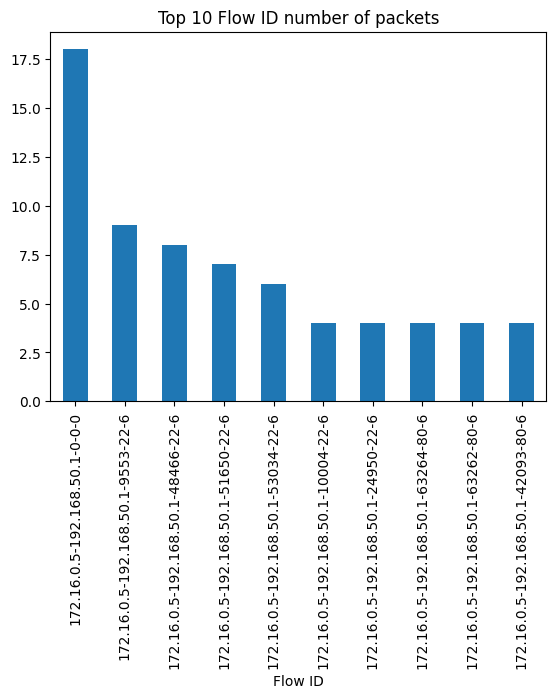

In [114]:
mask_bening = operational_df['label'] != 'benign'
df_flow_id = operational_df[mask_bening].groupby('Flow ID').count().sort_values(by=' Source IP', ascending=False)[:10]
df_flow_id[' Source IP'].plot(kind='bar', title='Top 10 Flow ID number of packets')

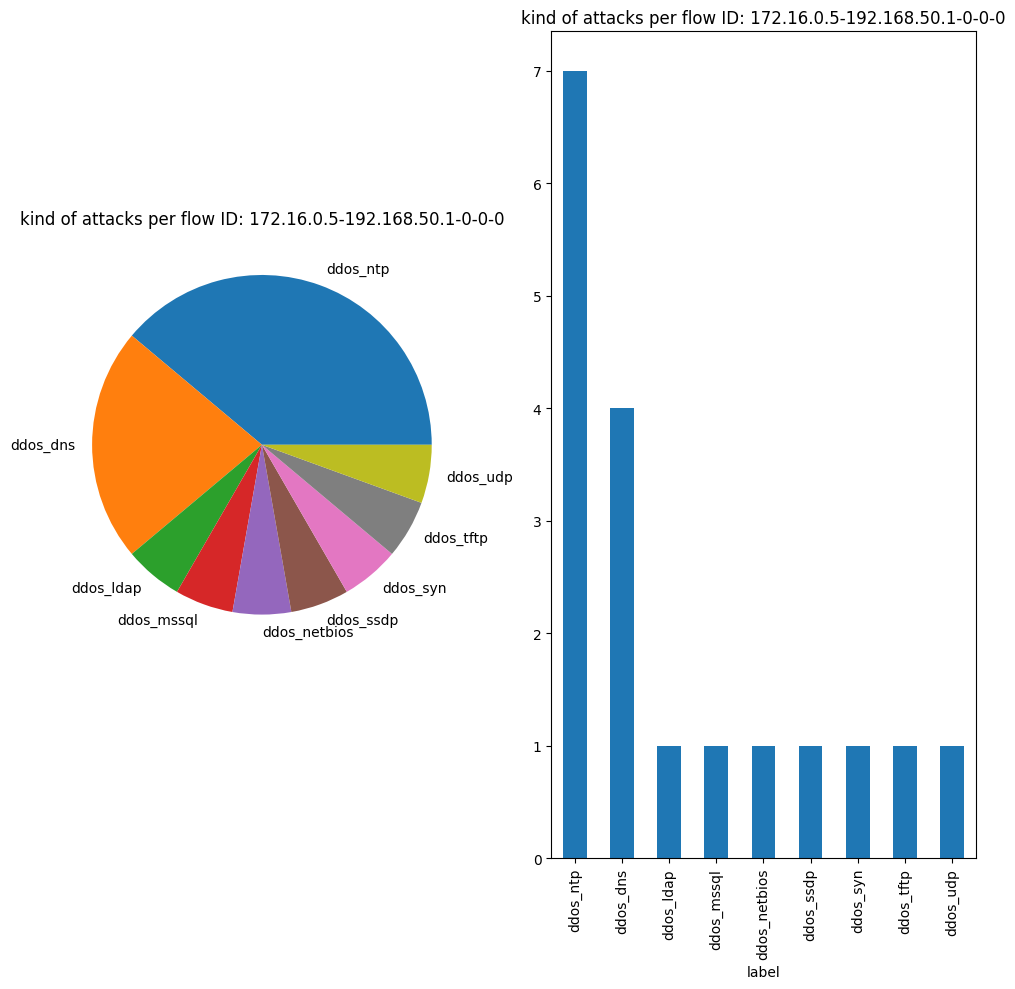

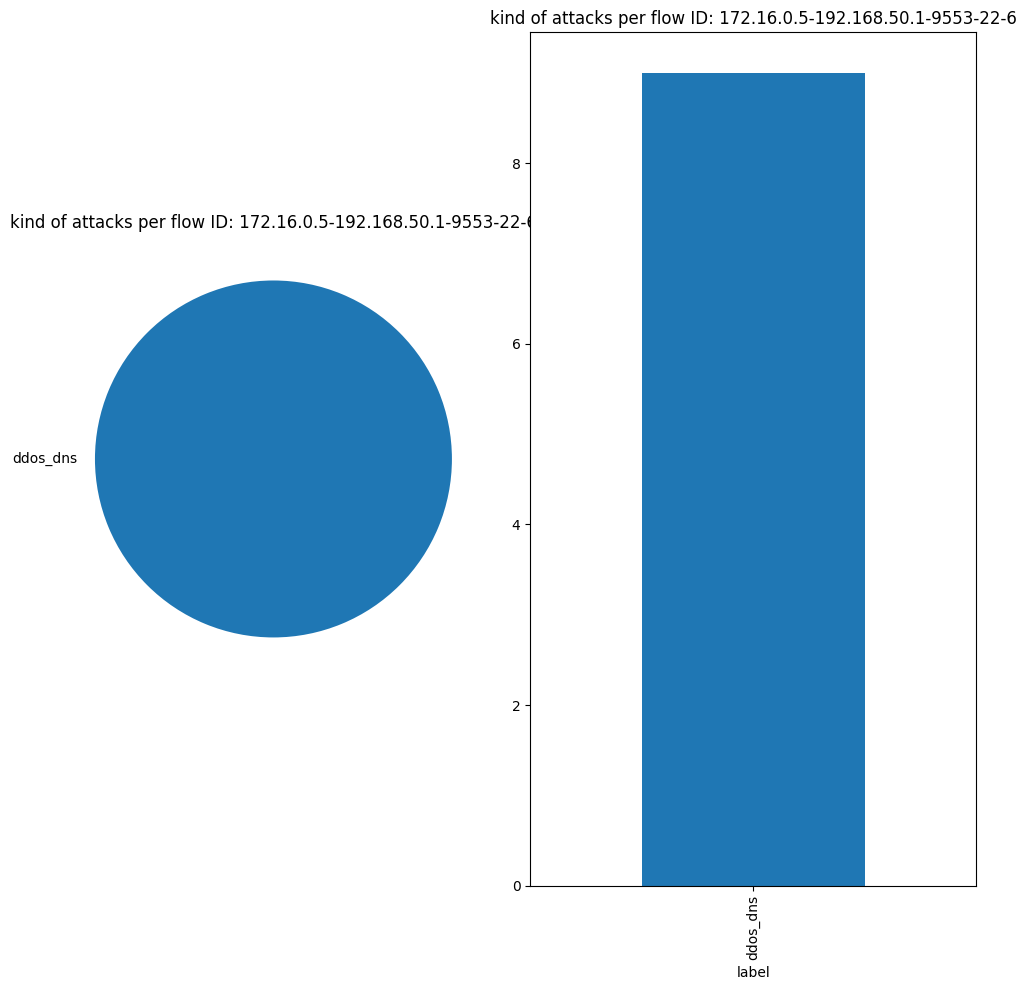

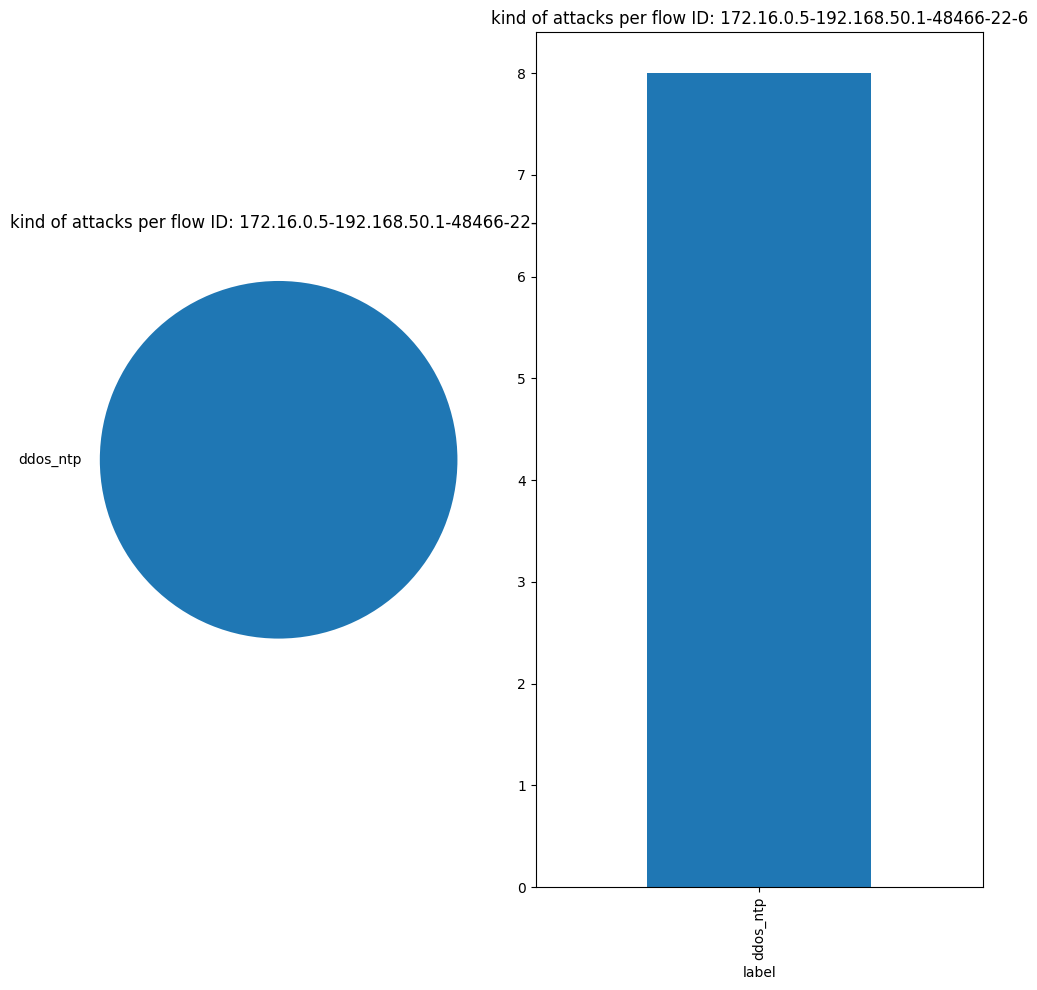

In [115]:
for i, index in enumerate(df_flow_id.index[:3]):
    fig, ax = plt.subplots(1,2, figsize=(10,10))
    mask_index = operational_df['Flow ID'] == index
    df_plot = operational_df[mask_index].groupby('label').count().sort_values(by='Flow ID', ascending=False)['Flow ID']
    df_plot.plot(kind='pie', title= f'kind of attacks per flow ID: {index}', ax=ax[0])
    ax[0].set_ylabel('')
    df_plot.plot(kind='bar', title= f'kind of attacks per flow ID: {index}', ax=ax[1])
    plt.tight_layout()



Analysis of the top 10 common link (Flow ID, Source Port, Destination Port) and the relative attack (the benign flow has been removed) based on the number of packets exchanged

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


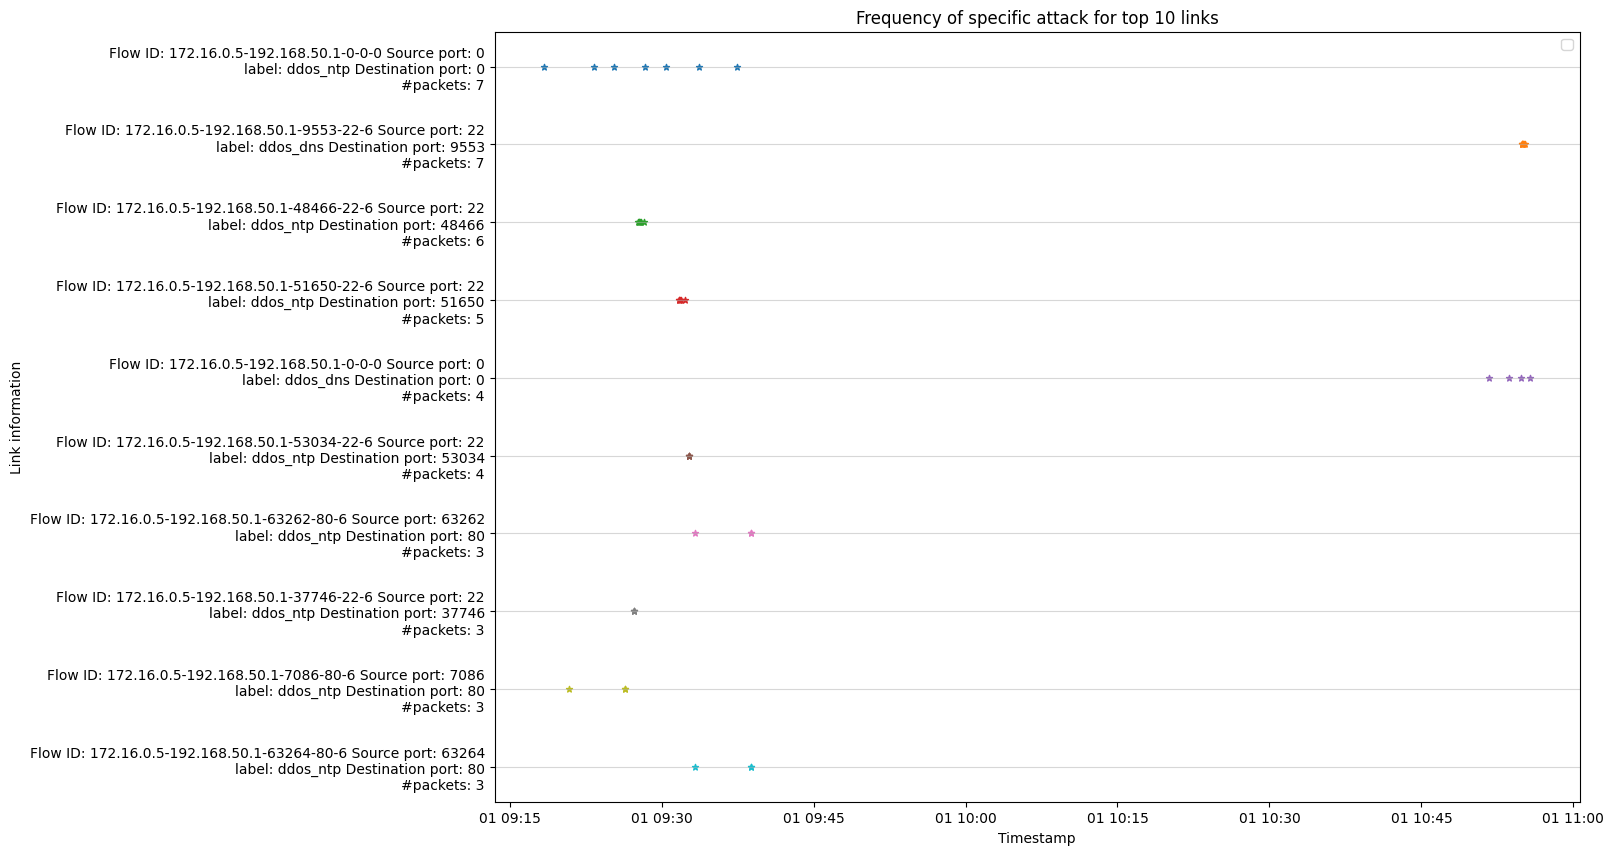

In [116]:
top_10_link = operational_df[operational_df['label'] != 'benign'].groupby(['Flow ID', 'label', ' Source Port', ' Destination Port']).count().sort_values(by=' Source IP', ascending=False).index[:10]
plt.figure(figsize=(14, 10))
ytick_labels = []
for n, link in enumerate(top_10_link):
    flow_id = link[0]
    flow_type = link[1]
    src_port = link[2]
    dst_port = link[3]
    df_link = operational_df[
        (operational_df['Flow ID'] == flow_id) &
        (operational_df[' Source Port'] == src_port) &
        (operational_df['label'] == flow_type) &
        (operational_df[ ' Destination Port'] == dst_port)
    ]
    plt.scatter(
        df_link.index,
        [10-n for _ in range(len(df_link))],
        s = 20, 
        marker = '*'
    )
    # create the label of each link for y-axis
    ytick_label = f'Flow ID: {flow_id} ' + \
                  f'Source port: {src_port}\n' + \
                  f'label: {flow_type} ' + \
                  f'Destination port: {dst_port}\n' + \
                  f'#packets: {len(df_link)}'
    ytick_labels.append(ytick_label)
plt.xlabel('Timestamp') 
plt.ylabel('Link information')
# the first list the the location of the label
# the second list is the label you want to assign to each location
plt.yticks([x for x in range(10,0,-1)], ytick_labels) 
plt.title('Frequency of specific attack for top 10 links')
plt.grid(axis='y', alpha=0.5)
plt.legend()
plt.show()

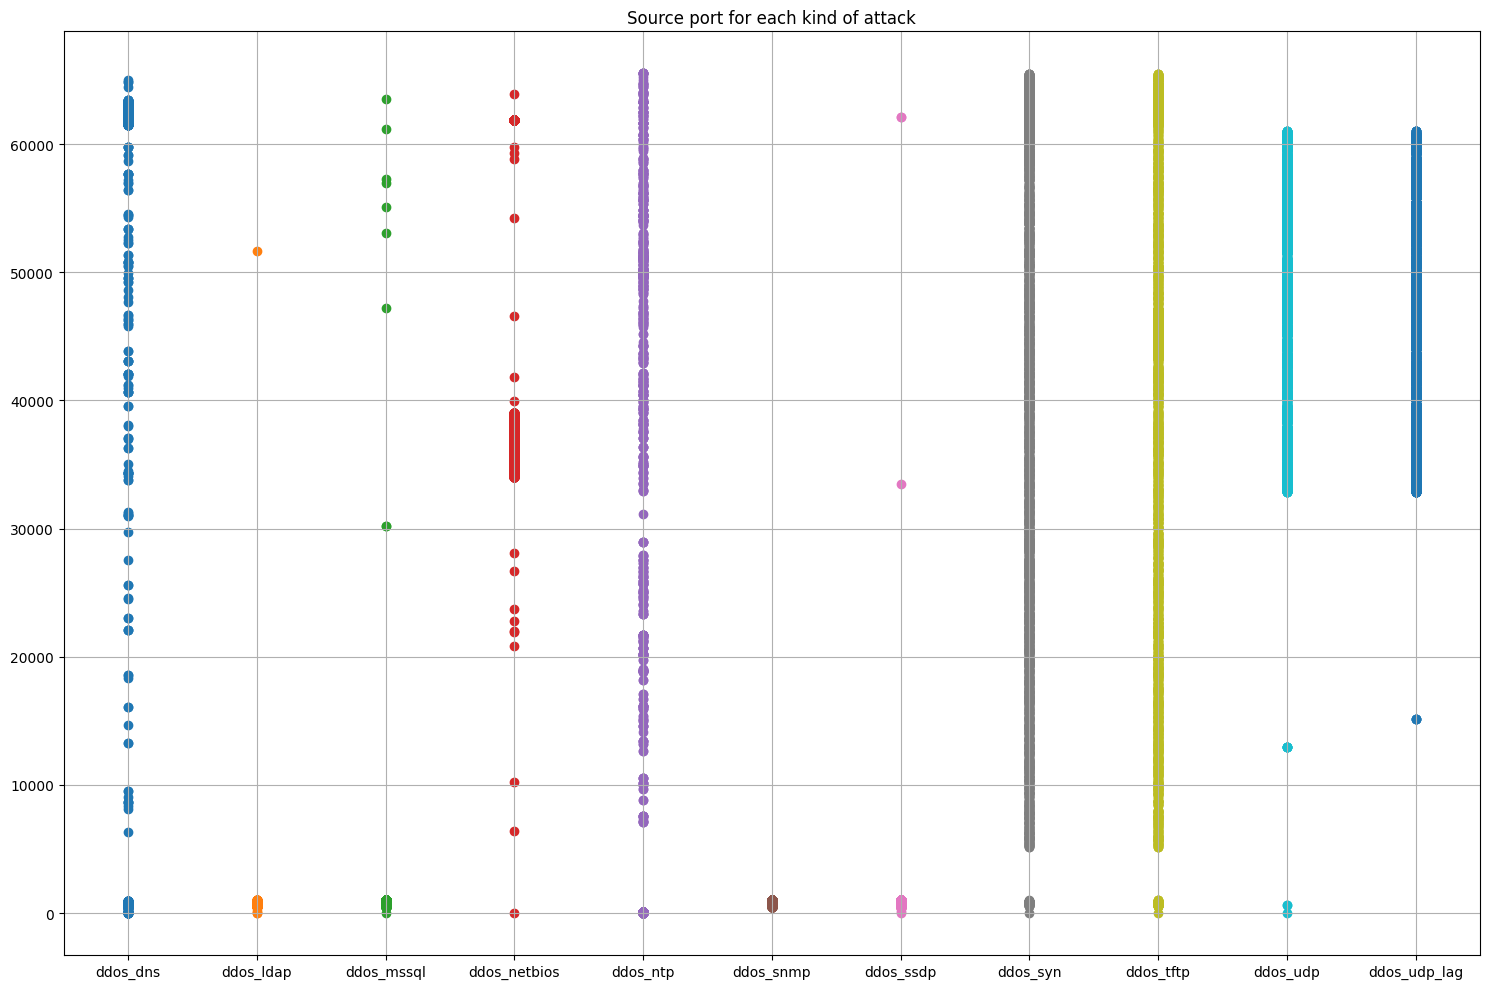

In [117]:
operational_df = ddos_data.copy()
operational_df[' Timestamp'] = pd.to_datetime(operational_df[' Timestamp'])
operational_df.set_index(' Timestamp', inplace=True)
mask_malicious = operational_df['label'] != 'benign'
df_result = operational_df[mask_malicious]
ax, figure = plt.subplots(figsize=(15,10))
labels = df_result.groupby('label').count().index
for attack in labels:
    mask_at = df_result['label'] == attack
    plt.scatter(data=df_result[mask_at], x='label', y=' Source Port')
plt.title('Source port for each kind of attack')
plt.grid()
plt.tight_layout()
plt.show()
    

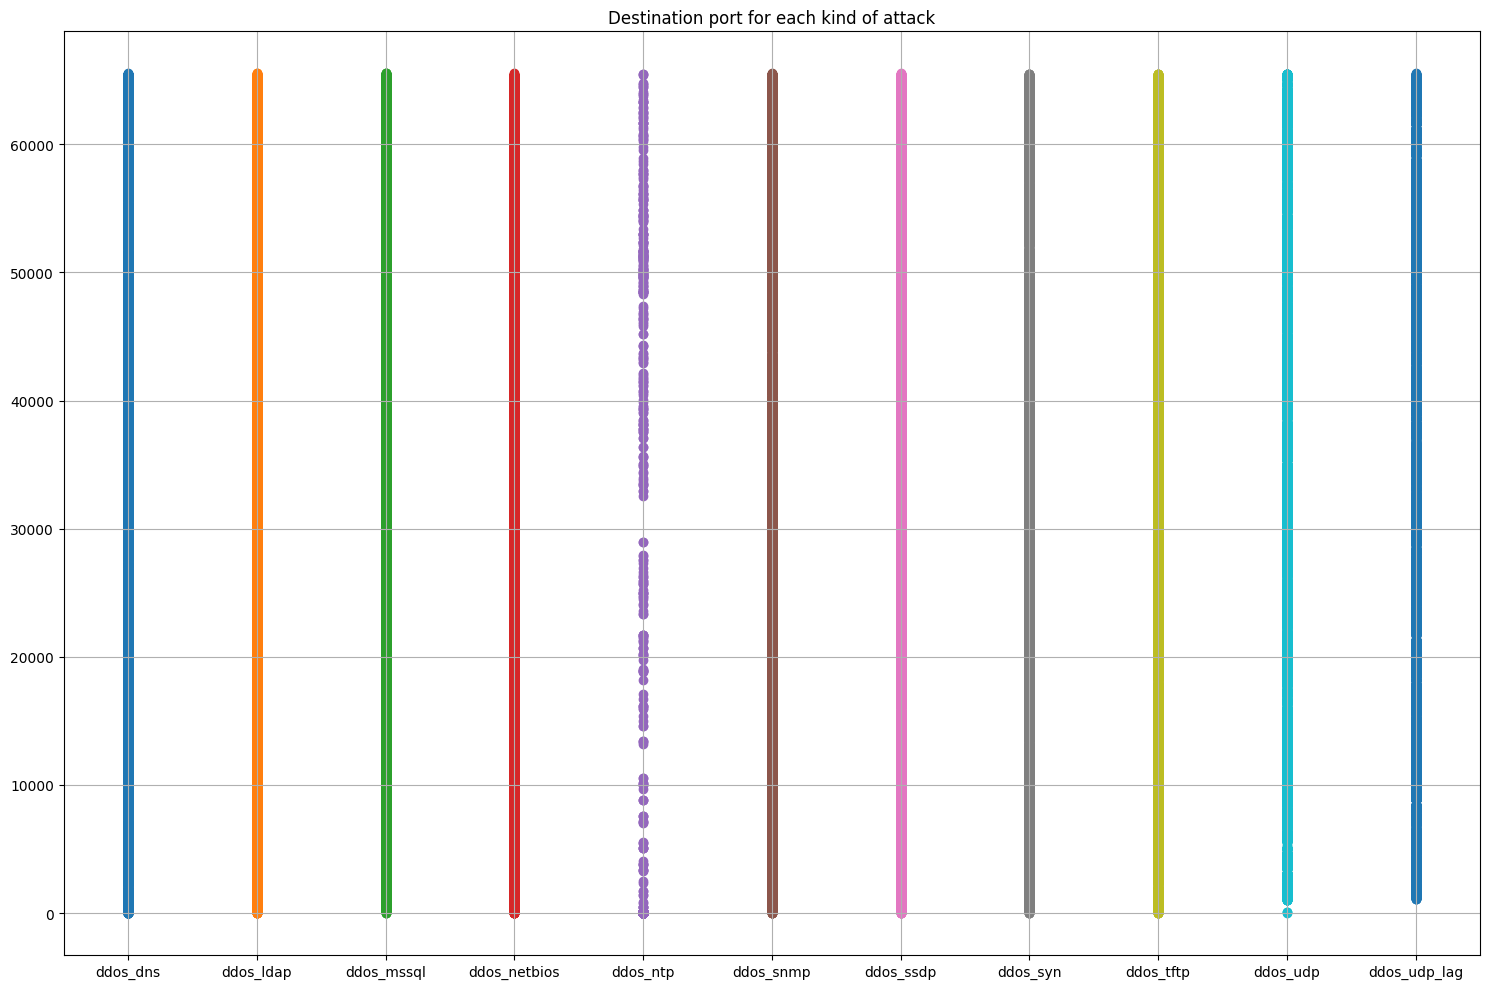

In [118]:
operational_df = ddos_data.copy()
operational_df[' Timestamp'] = pd.to_datetime(operational_df[' Timestamp'])
operational_df.set_index(' Timestamp', inplace=True)
mask_malicious = operational_df['label'] != 'benign'
df_result = operational_df[mask_malicious]
ax, figure = plt.subplots(figsize=(15,10))
labels = df_result.groupby('label').count().index
for attack in labels:
    mask_at = df_result['label'] == attack
    plt.scatter(data=df_result[mask_at], x='label', y=' Destination Port')
plt.title('Destination port for each kind of attack')
plt.grid()
plt.tight_layout()
plt.show()
    

Evauluating Packet length for each different kind of flow (attack or benign) 

Text(0.5, 1.0, 'Total Number of Bwd Packets for each kind of flow')

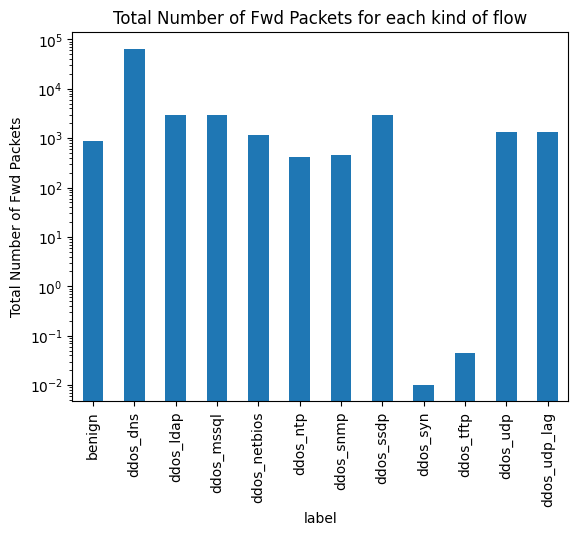

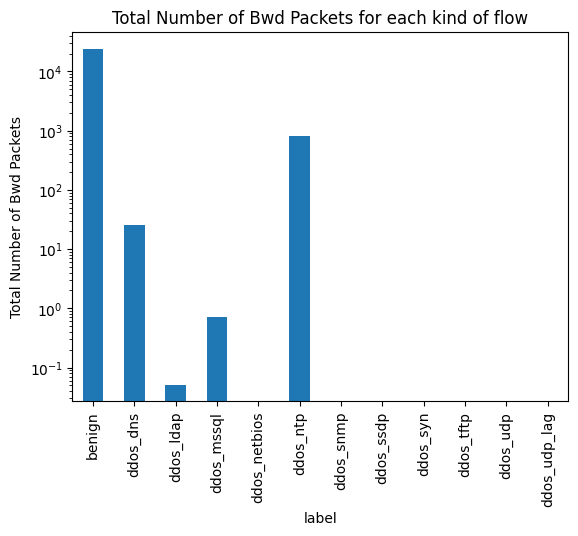

In [119]:
fig, ax = plt.subplots()
grouped_df = operational_df.groupby('label')
grouped_df['Total Length of Fwd Packets'].mean().plot(kind='bar')
plt.yscale('log')
plt.ylabel('Total Number of Fwd Packets')
plt.title('Total Number of Fwd Packets for each kind of flow')
fig, ax = plt.subplots()
grouped_df[' Total Length of Bwd Packets'].mean().plot(kind='bar')
plt.yscale('log')
plt.ylabel('Total Number of Bwd Packets')
plt.title('Total Number of Bwd Packets for each kind of flow')



In [120]:
def convert_milliseconds_to_msm(milliseconds):
    minutes, remainder = divmod(milliseconds, 60000)
    seconds, milliseconds = divmod(remainder, 1000)
    return "{:02}:{:02}:{:02}".format(int(minutes), int(seconds), int(milliseconds))

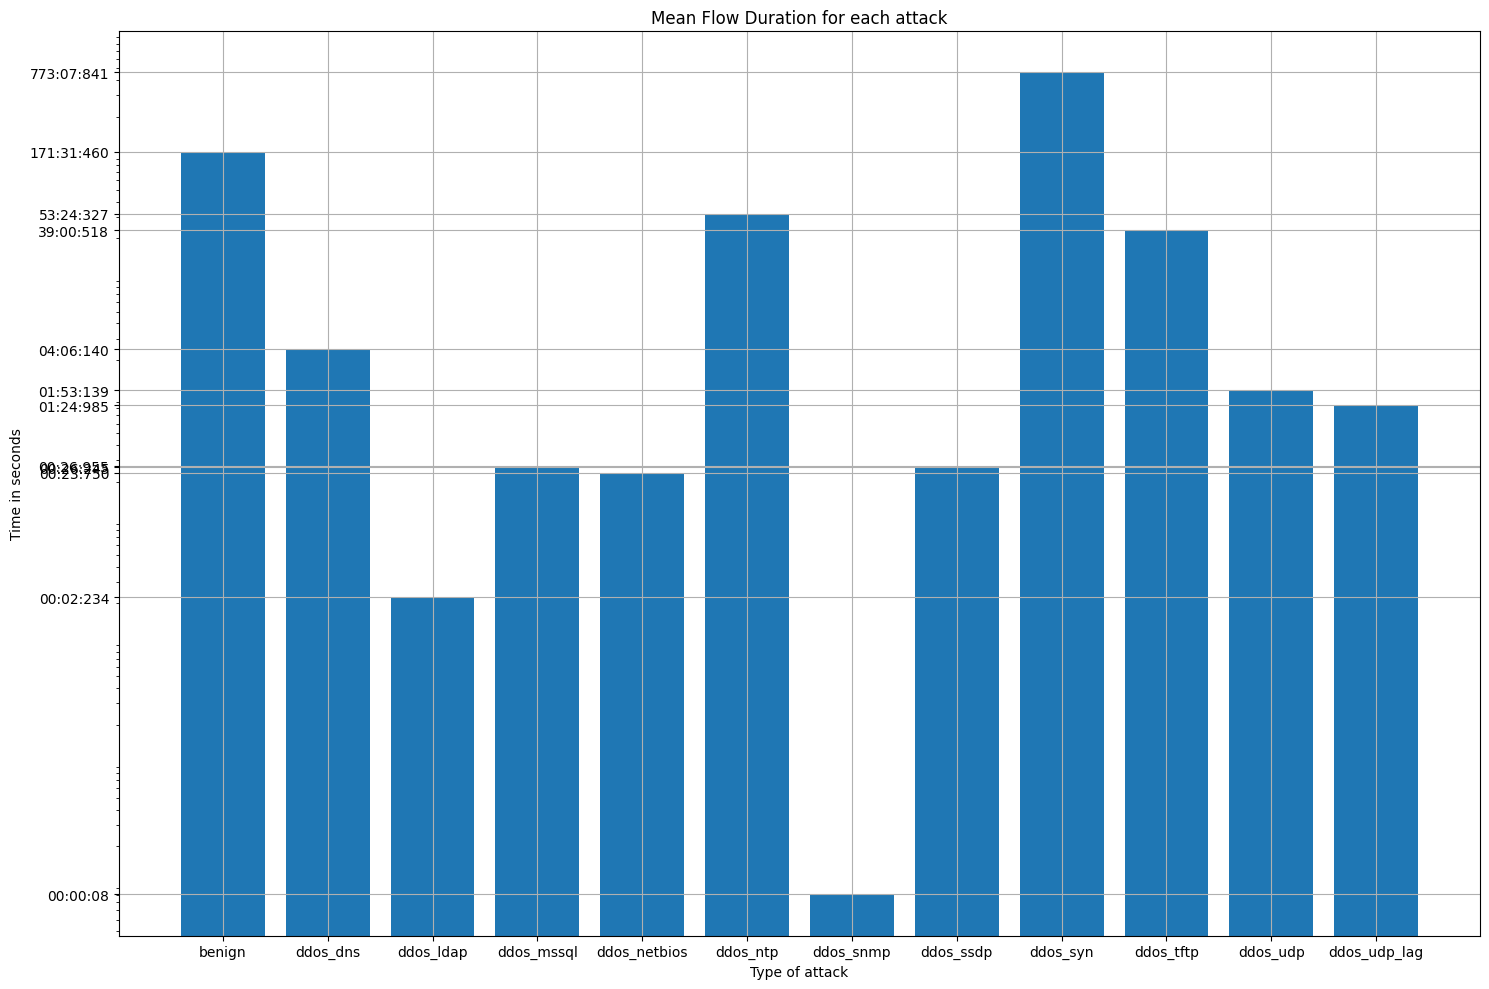

In [121]:
operational_df['M:S:MS Flow Duration'] = operational_df[' Flow Duration'].apply(convert_milliseconds_to_msm)
y_ticks = grouped_df[' Flow Duration'].mean().sort_values().apply(convert_milliseconds_to_msm).values

fig, ax = plt.subplots(figsize=(15, 10))
plt.bar(grouped_df[' Flow Duration'].mean().index, grouped_df[' Flow Duration'].mean())
plt.yscale('log')
plt.yticks(grouped_df[ ' Flow Duration'].mean().sort_values(), y_ticks)
plt.xlabel('Type of attack')
plt.ylabel('Time in seconds')
plt.title('Mean Flow Duration for each attack')
plt.tight_layout()
plt.grid()
plt.show()

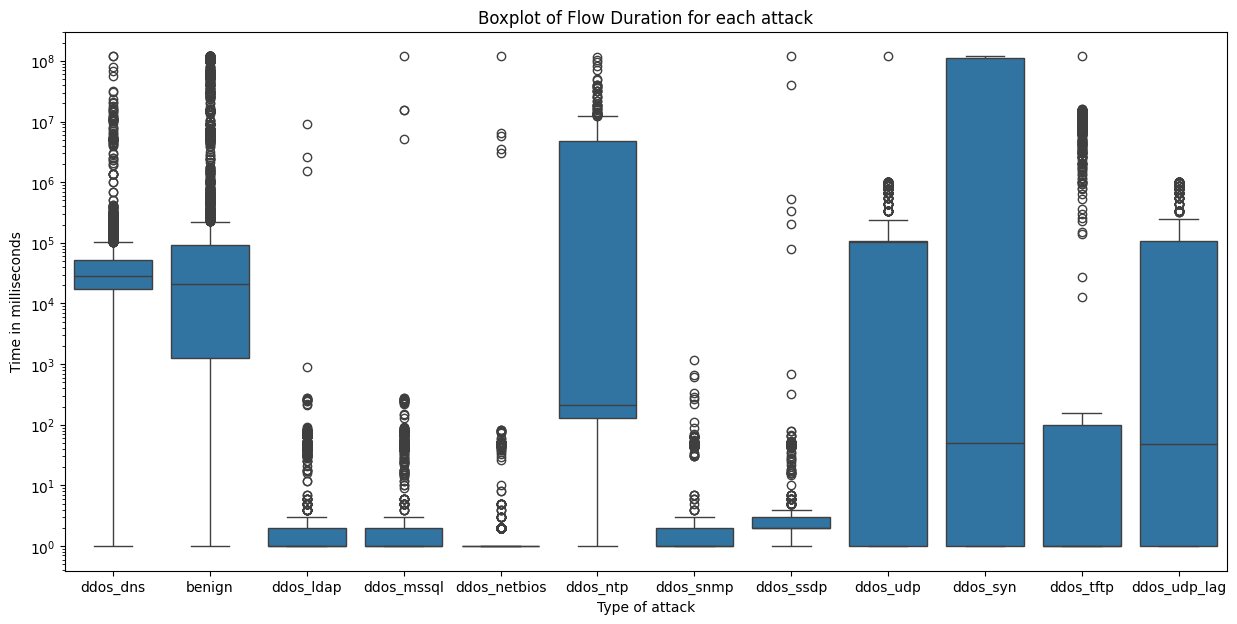

In [122]:
fig, ax= plt.subplots(figsize=(15, 7))

sns.boxplot(data=operational_df, x='label', y=' Flow Duration')
ax.set_yscale('log')
plt.xlabel('Type of attack')
plt.ylabel('Time in milliseconds')
plt.title('Boxplot of Flow Duration for each attack')
plt.show()

Inbound Analysis

<Axes: xlabel='label'>

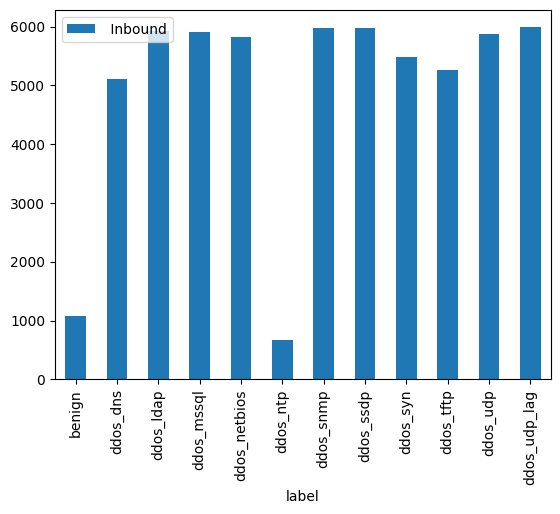

In [123]:
mask_inbound = operational_df[' Inbound'] != 0
at_inbound_df = operational_df[mask_inbound]
at_inbound_df[[' Inbound', 'label']].groupby('label').count().plot(kind='bar')

<Axes: xlabel='label'>

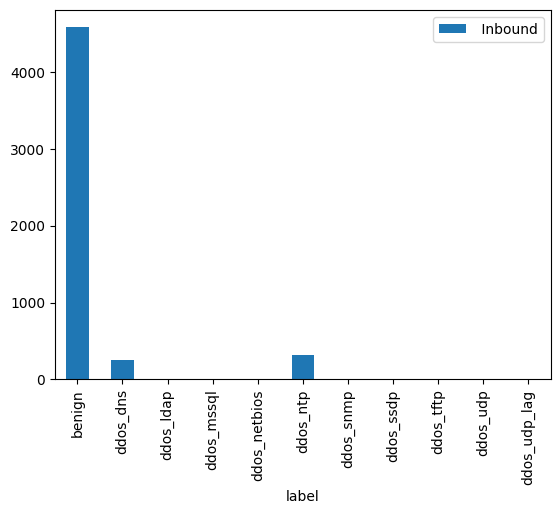

In [124]:
mask_inbound = operational_df[' Inbound'] != 1
at_inbound_df = operational_df[mask_inbound]
at_inbound_df[[' Inbound', 'label']].groupby('label').count().plot(kind='bar')

In [181]:
print(operational_df[[' Source IP', 'Total Length of Fwd Packets']].groupby(' Source IP').agg(['max','min','mean','std']).fillna(.0))

               Total Length of Fwd Packets                            
                                       max    min    mean          std
 Source IP                                                            
0.0.0.0                             5400.0  900.0  2925.0  1710.263138
104.36.115.113                         0.0    0.0     0.0     0.000000
104.88.102.115                        62.0    0.0    31.0    35.795717
104.88.29.71                           0.0    0.0     0.0     0.000000
104.88.46.113                          0.0    0.0     0.0     0.000000
...                                    ...    ...     ...          ...
8.43.72.97                             0.0    0.0     0.0     0.000000
8.43.72.98                             0.0    0.0     0.0     0.000000
8.6.0.1                                0.0    0.0     0.0     0.000000
94.31.29.44                            0.0    0.0     0.0     0.000000
96.6.27.46                            62.0   62.0    62.0     0.000000

[216 

In [183]:
print(operational_df[[' Source IP', ' Total Length of Bwd Packets']].groupby(' Source IP').agg(['max','min','mean','std']).fillna(.0))

                Total Length of Bwd Packets               
                                        max  min mean  std
 Source IP                                                
0.0.0.0                                 0.0  0.0  0.0  0.0
104.36.115.113                          0.0  0.0  0.0  0.0
104.88.102.115                          0.0  0.0  0.0  0.0
104.88.29.71                            0.0  0.0  0.0  0.0
104.88.46.113                           0.0  0.0  0.0  0.0
...                                     ...  ...  ...  ...
8.43.72.97                              0.0  0.0  0.0  0.0
8.43.72.98                              0.0  0.0  0.0  0.0
8.6.0.1                                 0.0  0.0  0.0  0.0
94.31.29.44                             0.0  0.0  0.0  0.0
96.6.27.46                              0.0  0.0  0.0  0.0

[216 rows x 4 columns]


In [164]:
print(operational_df[[' Source IP',' Total Fwd Packets', ' Fwd Packet Length Max']].groupby(' Source IP')[[' Total Fwd Packets',' Fwd Packet Length Max']].fillna(.0).sort_values(by = " Total Fwd Packets", ascending=False)[:5])

                             Total Fwd Packets   Fwd Packet Length Max
 Timestamp                                                            
2018-12-01 11:22:40.254769               85894                     0.0
2018-12-01 11:32:32.915441               60959                     0.0
2018-12-01 12:23:13.663425               49476                     0.0
2018-12-01 13:30:30.750958                4360                     0.0
2018-12-01 11:47:08.465544                4114                     0.0


PCA 

In [ ]:
from sklearn.preprocessing import StandardScaler
df = ddos_data.copy()
df.set_index(' Timestamp', inplace=True)
scaler = StandardScaler()
column_to_remove = ['Flow ID', ' Source IP', ' Destination IP', 'SimillarHTTP', 'label']
df[df.columns.drop(column_to_remove)] = scaler.fit_transform(df[df.columns.drop(column_to_remove)])
df_scaled = df.copy()
correlation_matrix = df.corr().abs().round(2)
plt.figure(figsize=(30,30))
sns.heatmap(correlation_matrix, cmap='Blues', annot=True, vmin=0, vmax=1, cbar_kws={'label':'Correlation'})
plt.xlabel('Feature')
plt.ylabel('Feature')
plt.title('Correlation matrix')
plt.show()

ModuleNotFoundError: No module named 'sklearn'

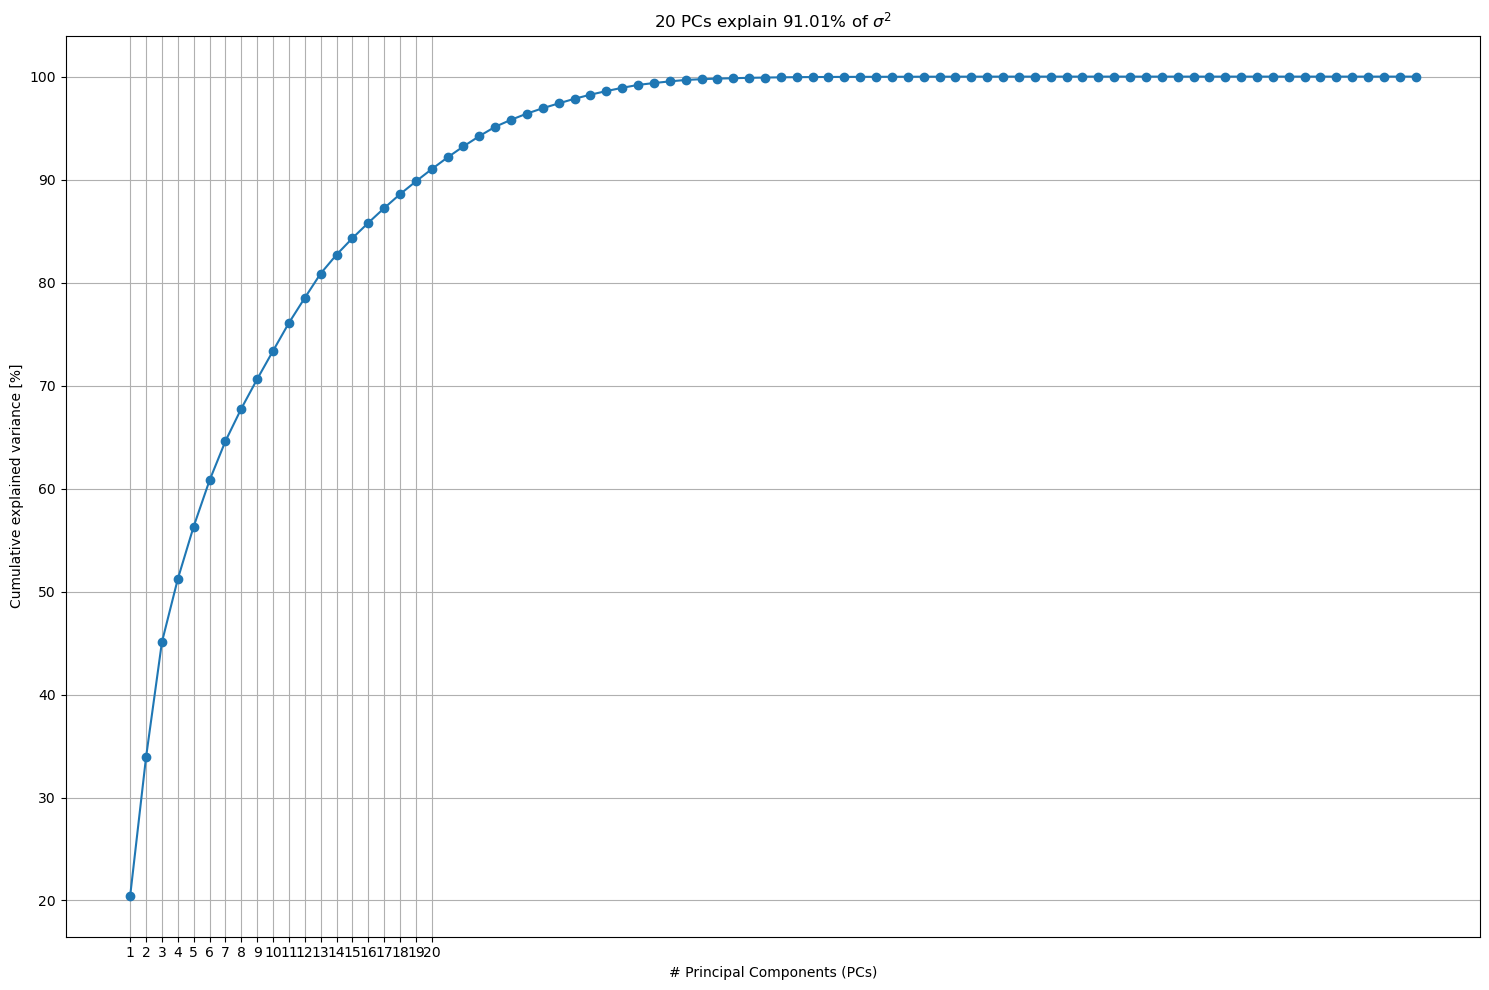

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(random_state=15)
pca.fit(df_scaled.drop(columns=['label', 'Flow ID', ' Source IP', ' Destination IP', 'SimillarHTTP']))

explained_variance = pca.explained_variance_ratio_
cumul_exp_var = np.cumsum(explained_variance)
perc_cumul_exp_var = cumul_exp_var*100

plt.figure(figsize=(15,10))
plt.plot(perc_cumul_exp_var, marker='o')
plt.xlabel('# Principal Components (PCs)')
plt.ylabel('Cumulative explained variance [%]')
plt.xticks([i for i in range(20)], [i for i in range (1,21)])
plt.grid()
plt.title(f'20 PCs explain {round(perc_cumul_exp_var[19], 2)}% of $\sigma^2$')
plt.tight_layout()
plt.show()

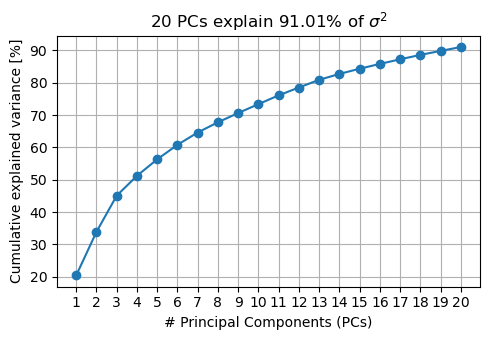

In [ ]:
pca = PCA(n_components=20, random_state=15)
pca.fit(df_scaled.drop(columns=['label', 'Flow ID', ' Source IP', ' Destination IP', 'SimillarHTTP']))
pca_result = pca.transform(df_scaled.drop(columns=['label', 'Flow ID', ' Source IP', ' Destination IP', 'SimillarHTTP']))

pca_df = pd.DataFrame(pca_result, columns=['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19', 'c20'])
pca_df.to_csv('pca_datafrane.csv', index=False)
explained_variance = pca.explained_variance_ratio_

# evaluate the total dataset variability while increasing the variables
cumul_exp_var = np.cumsum(explained_variance)

# percentage value to better understand the best number of components
perc_cumul_exp_var = cumul_exp_var * 100

# make the plot of cumulative explained variance wrt number of components
plt.figure(figsize=(5, 3.5))
plt.plot(perc_cumul_exp_var, marker='o')
plt.xlabel('# Principal Components (PCs)')
plt.ylabel('Cumulative explained variance [%]')
plt.xticks([i for i in range(20)], [i for i in range(1,21)])
plt.grid()
plt.title(f'20 PCs explain {round(perc_cumul_exp_var[19], 2)}% of $\sigma^2$')
plt.tight_layout()
plt.show()

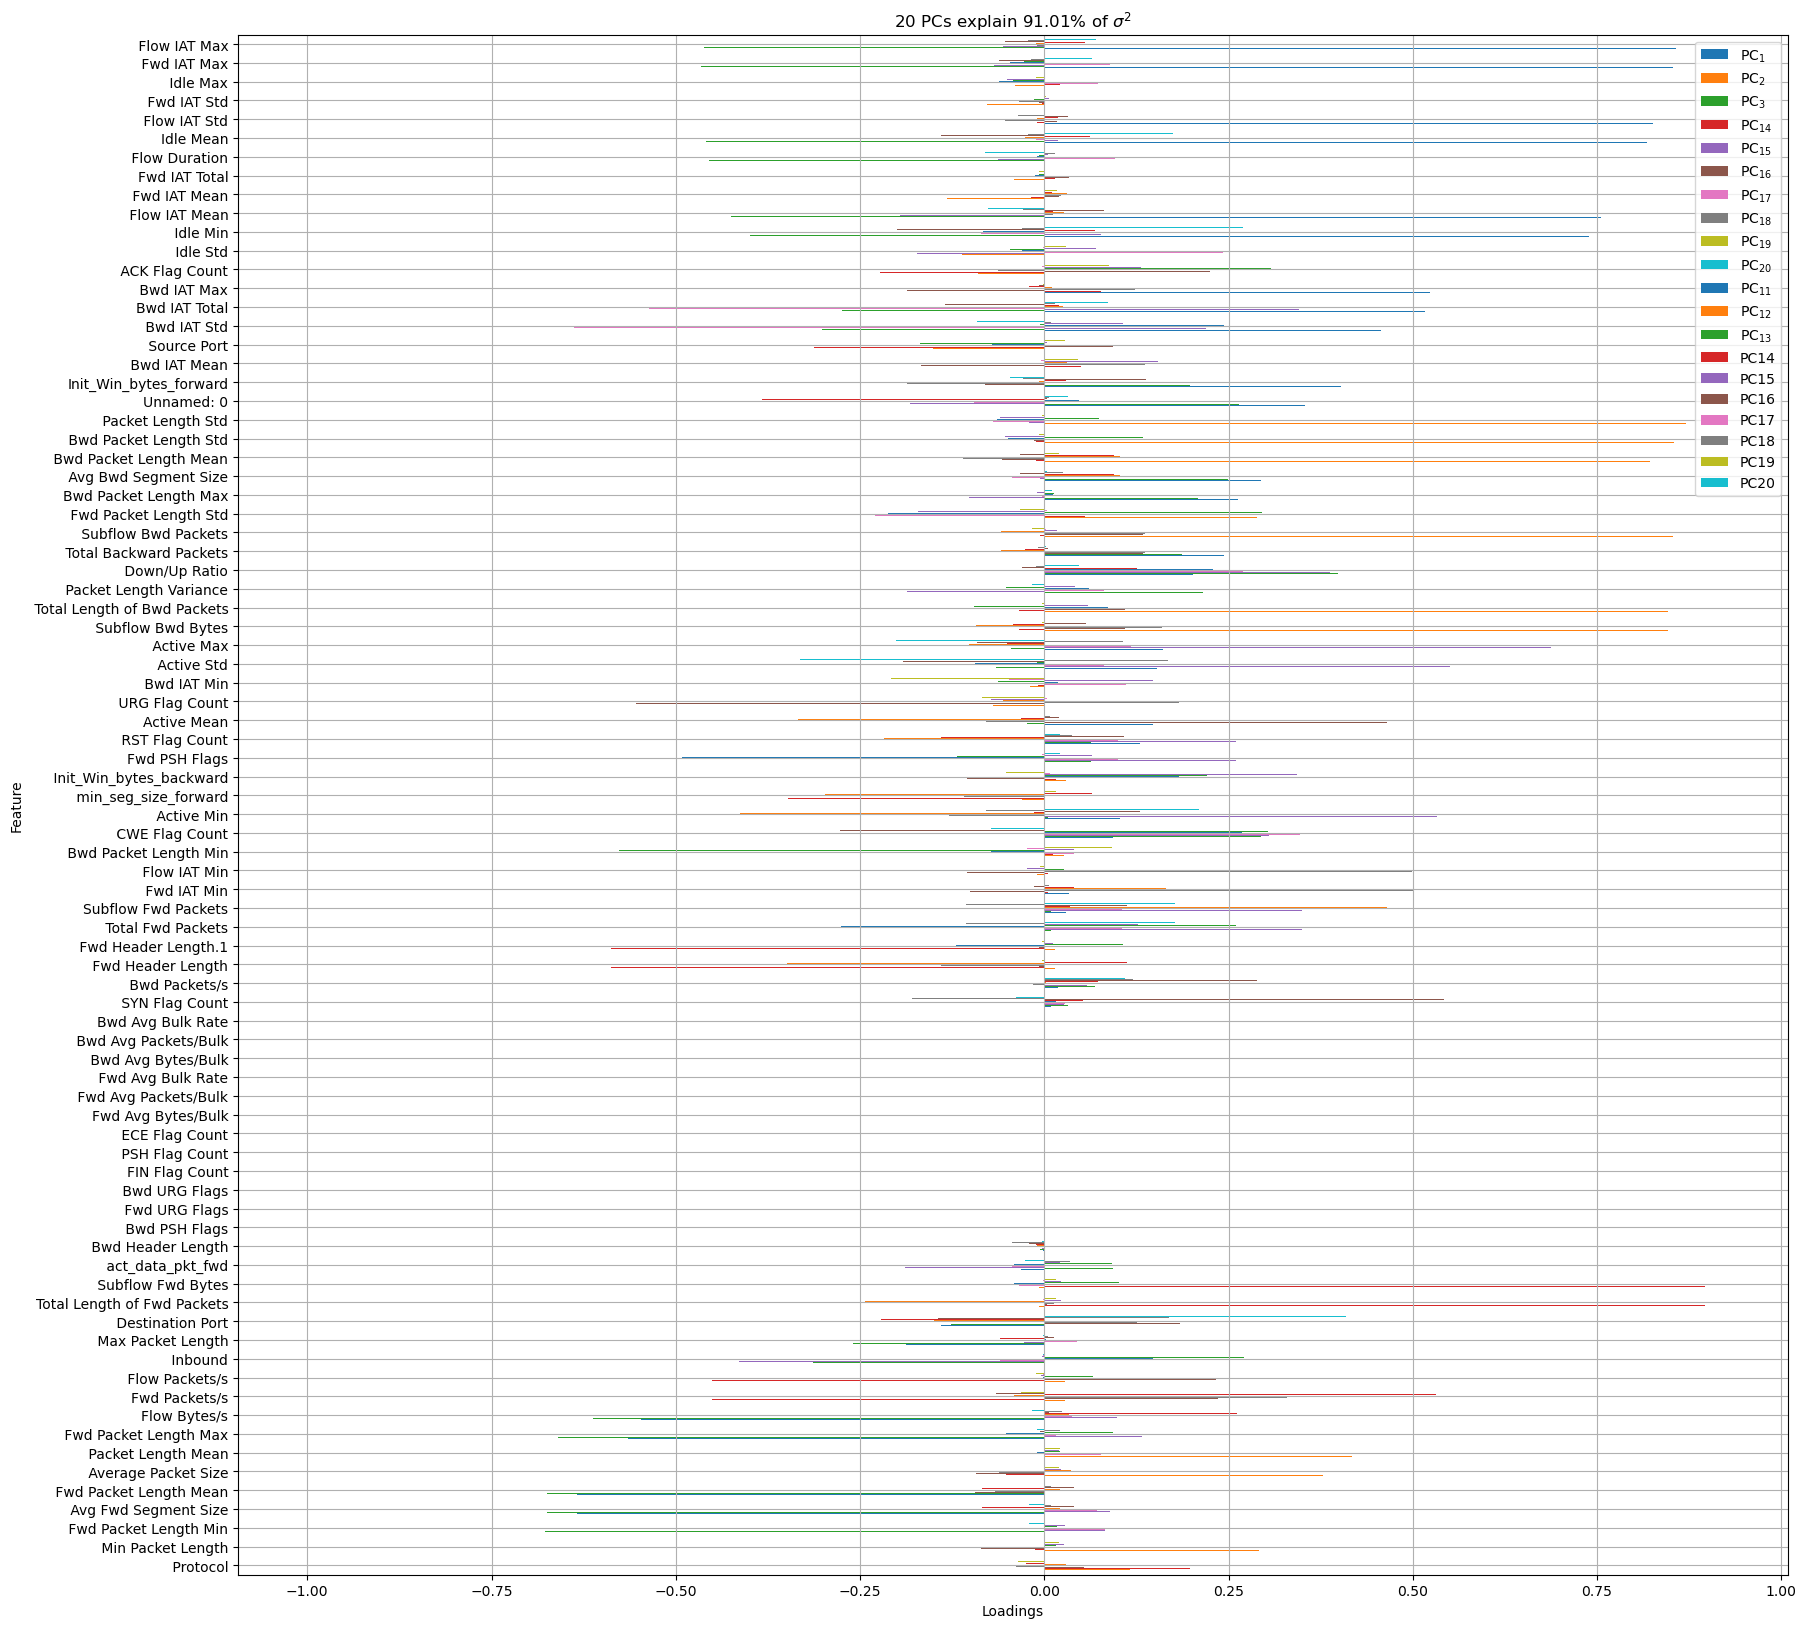

In [ ]:
loadings = pd.DataFrame(
    data = pca.components_.T * np.sqrt(pca.explained_variance_), 
    columns = [f'PC{i}' for i in range(1, 21)],
    index = df_scaled.drop(columns=['label', 'Flow ID', ' Source IP', ' Destination IP', 'SimillarHTTP']).columns
)

plt.figure(figsize=(20,20))
loadings = loadings[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20']]
loadings.sort_values(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
                       'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20']).rename(columns={'PC1':'PC$_{1}$', 'PC2':'PC$_{2}$',
        'PC3':'PC$_{3}$', 'PC4':'PC$_{4}$', 'PC5':'PC$_{5}$', 'PC6':'PC$_{6}$', 'PC7':'PC$_{7}$', 'PC8':'PC$_{8}$', 'PC9':'PC$_{9}$', 'PC10':'PC$_{10}$', 'PC11':'PC$_{11}$', 'PC12':'PC$_{12}$',
        'PC13':'PC$_{13}$', 'PC4':'PC$_{14}$', 'PC5':'PC$_{15}$', 'PC6':'PC$_{16}$', 'PC7':'PC$_{17}$', 'PC8':'PC$_{18}$', 'PC9':'PC$_{19}$', 'PC10':'PC$_{20}$'}).plot.barh(ax=plt.gca())
plt.grid()
plt.xlabel('Loadings')
plt.ylabel('Feature')
plt.title(f'20 PCs explain {round(perc_cumul_exp_var[19], 2)}% of $\sigma^2$')
plt.show()

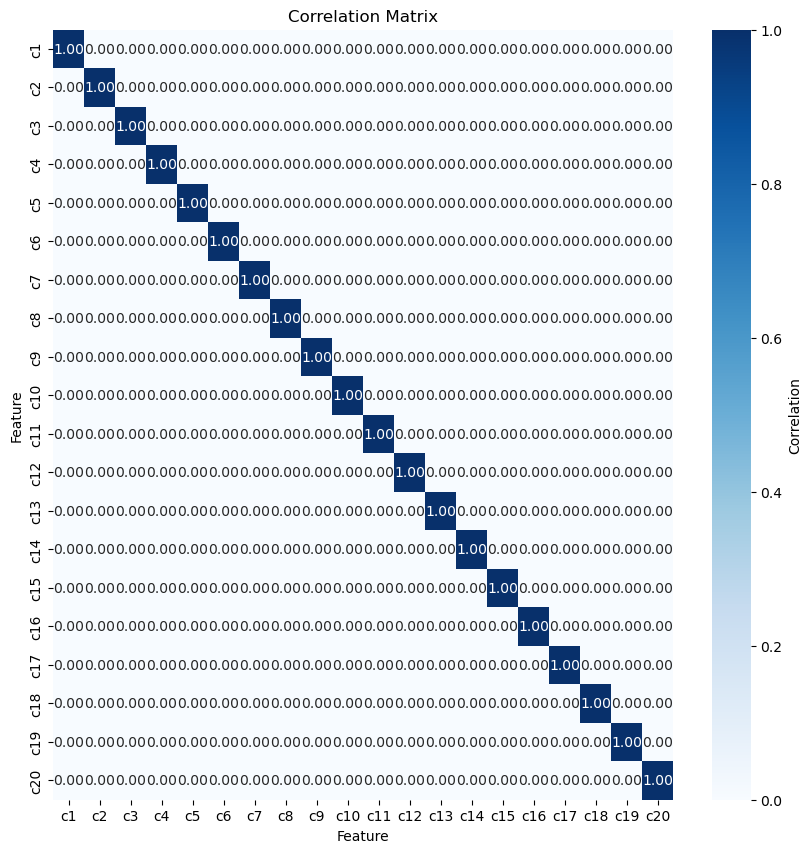

In [ ]:
pca_correlation_matrix = pca_df.corr().abs()

plt.figure(figsize=(10,10))
sns.heatmap(pca_correlation_matrix, cmap='Blues', annot=True, vmin=0, vmax=1, cbar_kws={'label':'Correlation'}, fmt='.2f')
plt.xlabel('Feature')
plt.ylabel('Feature')
plt.title('Correlation Matrix')
plt.show()